<a href="https://colab.research.google.com/github/VladislavsLuksha/FindingFrequentItemsets/blob/main/finding_frequent_itemsets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####Finding frequent itemsets 
Uladzislau Luksha
964000

## Loading Kaggle Dataset 

In [ ]:
#installing Kaggle library and loading the dataset
! pip install kaggle
! mkdir ~/.kaggle
import   os  
os.environ["KAGGLE_USERNAME"] = 'vladislavluksha'
os.environ["KAGGLE_KEY"] = 'b83964b8d0ecb107548fb4c099ee4d94'

!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 13.2G/13.2G [01:24<00:00, 220MB/s]
100% 13.2G/13.2G [01:24<00:00, 169MB/s]


In [ ]:
#Unzipping all individual files from the dataset
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows


Archive:  ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip
  inflating: 0819_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0820_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0821_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0822_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0823_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0824_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0825_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0826_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0827_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0828_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0829_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0830_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0831_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0901_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0902_UkraineCombinedTweetsDeduped.csv.gzip  
  inflating: 0903_UkraineCombinedTweetsDeduped.csv.gzip  
  inflat

In [ ]:
# installing and importing pyspark and other libraries
!pip install pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, countDistinct, udf, lower, regexp_replace, size, explode, split, trim, expr

from pyspark.sql.types import StructType,StructField,ArrayType,StringType


from pyspark.ml.feature import Tokenizer, StopWordsRemover, Normalizer

from pyspark.sql.types import DoubleType

import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import re
import csv

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#using tweets from Dec 6 2022 to Dec 11 2022
twitter = [ "1206_UkraineCombinedTweetsDeduped.csv.gzip",
           "1207_UkraineCombinedTweetsDeduped.csv.gzip",
          "1208_UkraineCombinedTweetsDeduped.csv.gzip",
           "1209_UkraineCombinedTweetsDeduped.csv.gzip",
           "1210_UkraineCombinedTweetsDeduped.csv.gzip",
           "1211_UkraineCombinedTweetsDeduped.csv.gzip"]

In [ ]:
ukraine = []

for day in twitter:
  df = pd.read_csv(day, compression='gzip', encoding='utf-8', quoting=csv.QUOTE_ALL)
  ukraine.append(df)

ukraine_combined = pd.concat(ukraine, axis=0)
print(f"total number of rows {ukraine_combined.shape[0]} and columns {ukraine_combined.shape[1]}")

total number of rows 279769 and columns 29


In [ ]:
ukraine_combined.head()

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
0,62140,901621364,tina_abre,Female Elvis The Song https://t.co/GoQupu0zVT ...,England,1486,5580,22197,2012-10-24 11:02:51,1599916529528631297,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-12-06 07:27:21.659159
1,62141,901621364,tina_abre,Female Elvis The Song https://t.co/GoQupu0zVT ...,England,1486,5580,22197,2012-10-24 11:02:51,1599916530292113409,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-12-06 07:27:21.647209
2,62142,41240677,ekekobbi,NaN,Iceland,183,189,31000,2009-05-19 23:30:16,1599916530955079685,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-12-06 14:43:02.647202
3,62143,22240612,AlArabiya_Eng,The Arab world’s leading source of global news...,Dubai,46,923454,331466,2009-02-28 08:31:32,1599916531961548800,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-12-06 09:12:30.480816
4,62144,18017198,TheAfricaReport,"The magazine for African politics, business & ...","Paris, France",1167,234743,42264,2008-12-10 11:24:06,1599916532473237504,...,0,NaN,0,0,NaN,False,0,0,NaN,2022-12-06 07:27:21.635162


In [ ]:
ukraine_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279769 entries, 0 to 43047
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               279769 non-null  int64  
 1   userid                   279769 non-null  int64  
 2   username                 279769 non-null  object 
 3   acctdesc                 239177 non-null  object 
 4   location                 174770 non-null  object 
 5   following                279769 non-null  int64  
 6   followers                279769 non-null  int64  
 7   totaltweets              279769 non-null  int64  
 8   usercreatedts            279769 non-null  object 
 9   tweetid                  279769 non-null  int64  
 10  tweetcreatedts           279769 non-null  object 
 11  retweetcount             279769 non-null  int64  
 12  text                     279769 non-null  object 
 13  hashtags                 279769 non-null  object 
 14  langu

In [ ]:
ukraine_combined['language'].unique()

array(['in', 'es', 'en', 'nl', 'te', 'ca', 'uk', 'th', 'de', 'und', 'pt',
       'ja', 'it', 'ru', 'fa', 'fr', 'ta', 'ht', 'hi', 'ar', 'pl', 'el',
       'et', 'da', 'pa', 'ka', 'cy', 'tl', 'ur', 'ro', 'bn', 'bg', 'is',
       'no', 'lt', 'sr', 'tr', 'gu', 'lv', 'cs', 'fi', 'iw', 'vi', 'zh',
       'ko', 'sl', 'ne', 'sv', 'mr', 'eu', 'or', 'ml', 'kn', 'si', 'hu',
       'my', 'am', 'dv', 'sd', 'ps', 'hy', 'km', 'ckb'], dtype=object)

In [ ]:
#calculating the precentage of each language
ukraine_combined['language'].value_counts(normalize=True) * 100

en     57.526030
und     9.936412
uk      6.585076
de      3.905365
fr      3.751309
         ...    
sd      0.001072
hy      0.001072
km      0.001072
dv      0.000357
ckb     0.000357
Name: language, Length: 63, dtype: float64

In [ ]:
language_list = ['en', 'uk']
ukraine_df = ukraine_combined[ukraine_combined['language'].isin(language_list)]
ukraine_df = ukraine_df[['userid','username','text','language']]
ukraine_df.head()

,userid,username,text,language
3,22240612,AlArabiya_Eng,ICYMI: #Oil prices rise 3 percent after OPEC+ ...,en
4,18017198,TheAfricaReport,A global fertiliser supply shock deepened by #...,en
5,1587111210809442304,vbl68,BRUTAL ATTACK (Dec 05) Ukraine TB-2s drones de...,en
6,4002394887,ibam_tr,🗞️News\n\nApproximately 6.5 million people in ...,en
11,19282353,swon,Entering at day #286 of Russia Invasion [UTC] ...,en


In [ ]:
ukraine_df.shape

(179363, 4)

In [ ]:
#removing duplicages
ukraine_df.drop_duplicates(subset=['text'],keep='last',inplace=True)
ukraine_df.shape


(176368, 4)

In [ ]:
#removing links
ukraine_df['text'] = ukraine_df['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [ ]:
# removing hashtag symbol 
ukraine_df['text'] = ukraine_df['text'].str.replace('#','') 

In [ ]:
#removing mentioning @ symbol
ukraine_df['text'] = ukraine_df['text'].str.replace('@','') 

In [ ]:
#initializing spark 
spark = SparkSession.builder.enableHiveSupport().getOrCreate()
from pyspark.sql import SQLContext
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sc = spark.sparkContext

In [ ]:
#remove punctuation function for further analysis of the language subsets
def removePunctuation(column):
   return lower(trim(regexp_replace(column,'\\p{Punct}',''))).alias('sentence')

In [ ]:
## Setup nltk and importing the necessary libraries
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string  

import time
from tqdm import tqdm
from pyspark.ml.fpm import FPGrowth



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#creating list of stopwords for the used languages
stopEN = stopwords.words('english')

In [ ]:
#nltk library does not contain the set of ukrainian stop words so I download them from the GitHub repository
stopUA = pd.read_csv("https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt", header=None, names=['stopwords'])
stopUA = stopUA.stopwords.tolist()

##Ukrainian Language Tweets 

In [ ]:
ukraine_ua= ukraine_df[ukraine_df['language']=='uk']
ukraine_ua.shape

(18394, 4)

In [ ]:
spark_ua=spark.createDataFrame(ukraine_ua) 
spark_ua.createOrReplaceTempView("ukraine_ua")
spark_ua.show(5)
spark_ua.cache()


+-------------------+---------------+--------------------+--------+
|             userid|       username|                text|language|
+-------------------+---------------+--------------------+--------+
|1546804625545859073|   GorbatenkoUA|tetiptashka Бо во...|      uk|
|         2687934091|      vybukhova|elriness odarkovk...|      uk|
|1498027981217935364|Mriya_dlia_Mrii|Там у Казахів три...|      uk|
|         2687934091|      vybukhova|У мене вже давно ...|      uk|
|1512034057936326662|  Diana00683825|iivazag0 jinachak...|      uk|
+-------------------+---------------+--------------------+--------+
only showing top 5 rows



DataFrame[userid: bigint, username: string, text: string, language: string]

In [ ]:
#selecting only text columns
spark_ua = spark_ua.select("text")
spark_ua.show(n = 5)
     

+--------------------+
|                text|
+--------------------+
|tetiptashka Бо во...|
|elriness odarkovk...|
|Там у Казахів три...|
|У мене вже давно ...|
|iivazag0 jinachak...|
+--------------------+
only showing top 5 rows



In [ ]:
#remove punctuation
spark_ua = spark_ua.select(removePunctuation(col('text')).alias("text"))
spark_ua.show(5)


+--------------------+
|                text|
+--------------------+
|tetiptashka бо во...|
|elriness odarkovk...|
|там у казахів три...|
|у мене вже давно ...|
|iivazag0 jinachak...|
+--------------------+
only showing top 5 rows



In [ ]:
#tokenization
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
spark_ua = spark_ua.withColumn("text", trim(col("text")))
spark_ua = tokenizer.transform(spark_ua)
spark_ua.show(5)


+--------------------+--------------------+
|                text|         words_token|
+--------------------+--------------------+
|tetiptashka бо во...|[tetiptashka, бо,...|
|elriness odarkovk...|[elriness, odarko...|
|там у казахів три...|[там, у, казахів,...|
|у мене вже давно ...|[у, мене, вже, да...|
|iivazag0 jinachak...|[iivazag0, jinach...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#removing stop words
remover = StopWordsRemover(stopWords=stopUA,inputCol='words_token', outputCol='tokenized')
spark_ua = remover.transform(spark_ua).select("text",'tokenized')

In [ ]:
#trim spaces
spark_ua = spark_ua.withColumn("tokenized", expr("filter(tokenized, elem -> elem != '')"))
spark_ua.show(5)


+--------------------+--------------------+
|                text|           tokenized|
+--------------------+--------------------+
|tetiptashka бо во...|[tetiptashka, дум...|
|elriness odarkovk...|[elriness, odarko...|
|там у казахів три...|[казахів, міста, ...|
|у мене вже давно ...|[передчуття, хоро...|
|iivazag0 jinachak...|[iivazag0, jinach...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#for performing FPGrowth algorithm we need unique words in tokenized column
get_uniques=udf(lambda x: list(set(x)), ArrayType(StringType()))

spark_ua = spark_ua.withColumn("tokenized", get_uniques(spark_ua.tokenized))
spark_ua.show(5)



+--------------------+--------------------+
|                text|           tokenized|
+--------------------+--------------------+
|tetiptashka бо во...|[tetiptashka, дум...|
|elriness odarkovk...|[odarkovka, приве...|
|там у казахів три...|[допомогти, пизді...|
|у мене вже давно ...|[росте, цікаво, п...|
|iivazag0 jinachak...|[iivazag0, відпов...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#FP Growth algorithm for ukrainian data
np.random.seed(1105)

fpGrowth = FPGrowth(itemsCol="tokenized", minSupport = 0.02)
model = fpGrowth.fit(spark_ua)
association_rules = model.associationRules
frequent_items = model.freqItemsets



In [ ]:
frequent_items.orderBy("freq",ascending=False).show(20,truncate=False)

+-------------------------+----+
|items                    |freq|
+-------------------------+----+
|[ukraine]                |1039|
|[зсу]                    |641 |
|[stoprussia]             |545 |
|[україна]                |537 |
|[україни]                |467 |
|[шо]                     |442 |
|[russiaisaterroriststate]|428 |
|[украина]                |378 |
|[standwithukraine]       |374 |
+-------------------------+----+



In [ ]:
frequentUA = ['ukraine','russia','russian','ukrainian','war','putin','ukrainerussiawar','russiaisaterroriststate','stoprussia','україна','війна','всу', 'путін', 'шо','украина','україни','росія','standwithukraine',"2",'ukrainerussianwar', 'має','10','зсу','–','—','россия','україні','взагалі','🇺🇦','войнасукраиной','вторжениероссии','війнапутіна','агрессияроссии']

In [ ]:
stopUA.extend(frequentUA)
stopUA = list(dict.fromkeys(stopUA))

In [ ]:
frequent_items.count()


9

In [ ]:
#performing FP-algorithm the second time

#tokenization
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
spark_ua = spark_ua.withColumn("text", trim(col("text")))
spark_ua = tokenizer.transform(spark_ua)

#stop-words removal
remover = StopWordsRemover(stopWords=stopUA,inputCol='words_token', outputCol='tokenized2')
spark_ua = remover.transform(spark_ua).select("text",'tokenized2')

#trim spaces
spark_ua = spark_ua.withColumn("tokenized2", expr("filter(tokenized2, elem -> elem != '')"))

#for performing FPGrowth algorithm we need unique words in tokenized column
get_uniques=udf(lambda x: list(set(x)), ArrayType(StringType()))

spark_ua = spark_ua.withColumn("tokenized2", get_uniques(spark_ua.tokenized2))
spark_ua.show(5)


+--------------------+--------------------+
|                text|          tokenized2|
+--------------------+--------------------+
|tetiptashka бо во...|[tetiptashka, дум...|
|elriness odarkovk...|[odarkovka, приве...|
|там у казахів три...|[допомогти, пизді...|
|у мене вже давно ...|[росте, цікаво, п...|
|iivazag0 jinachak...|[iivazag0, відпов...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#FP Growth algorithm for ukrainian data
np.random.seed(1105)
#lowering support to 0.005
fpGrowth = FPGrowth(itemsCol="tokenized2", minSupport = 0.005)
model = fpGrowth.fit(spark_ua)
association_rules = model.associationRules
frequent_items = model.freqItemsets



In [ ]:
frequent_items.orderBy("freq",ascending=False).show(20,truncate=False)

+---------+----+
|items    |freq|
+---------+----+
|[день]   |330 |
|[світло] |272 |
|[світла] |253 |
|[життя]  |245 |
|[знаю]   |231 |
|[людей]  |216 |
|[хочу]   |205 |
|[слава]  |199 |
|[нема]   |193 |
|[kyiv]   |188 |
|[фото]   |184 |
|[nasa]   |174 |
|[рф]     |165 |
|[війни]  |156 |
|[росії]  |144 |
|[kherson]|143 |
|[розумію]|142 |
|[грудня] |141 |
|[робити] |141 |
|[відео]  |139 |
+---------+----+
only showing top 20 rows



In [ ]:
ukraine_ru = ukraine_df[ukraine_df['language']=='ru']
ukraine_ru.shape

(0, 4)

##English Language Tweets


In [ ]:
ukraine_en = ukraine_df[ukraine_df['language']=='en']
ukraine_en.shape

(157974, 4)

In [ ]:
#removing emojis
ukraine_en = ukraine_en.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

In [ ]:
spark_en=spark.createDataFrame(ukraine_en) 
spark_en.createOrReplaceTempView("ukraine_en")
spark_en.show(5)
spark_en.cache()


+-------------------+---------------+--------------------+--------+
|             userid|       username|                text|language|
+-------------------+---------------+--------------------+--------+
|           22240612|  AlArabiya_Eng|ICYMI: Oil prices...|      en|
|           18017198|TheAfricaReport|A global fertilis...|      en|
|1587111210809442304|          vbl68|BRUTAL ATTACK (De...|      en|
|         4002394887|        ibam_tr|News\n\nApproxima...|      en|
|           19282353|           swon|Entering at day 2...|      en|
+-------------------+---------------+--------------------+--------+
only showing top 5 rows



DataFrame[userid: string, username: string, text: string, language: string]

In [ ]:
#selecting only text columns
spark_en = spark_en.select("text")
spark_en.show(n = 5)
     

+--------------------+
|                text|
+--------------------+
|ICYMI: Oil prices...|
|A global fertilis...|
|BRUTAL ATTACK (De...|
|News\n\nApproxima...|
|Entering at day 2...|
+--------------------+
only showing top 5 rows



In [ ]:
#remove punctuation
spark_en = spark_en.select(removePunctuation(col('text')).alias("text"))
spark_en.show(5)


+--------------------+
|                text|
+--------------------+
|icymi oil prices ...|
|a global fertilis...|
|brutal attack dec...|
|news\n\napproxima...|
|entering at day 2...|
+--------------------+
only showing top 5 rows



In [ ]:
#tokenization
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
spark_en = spark_en.withColumn("text", trim(col("text")))
spark_en = tokenizer.transform(spark_en)
spark_en.show(5)


+--------------------+--------------------+
|                text|         words_token|
+--------------------+--------------------+
|icymi oil prices ...|[icymi, oil, pric...|
|a global fertilis...|[a, global, ferti...|
|brutal attack dec...|[brutal, attack, ...|
|news\n\napproxima...|[news, , approxim...|
|entering at day 2...|[entering, at, da...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#removing stop words
remover = StopWordsRemover(stopWords=stopEN,inputCol='words_token', outputCol='tokenized')
spark_en = remover.transform(spark_en).select("text",'tokenized')

In [ ]:
#trim spaces
spark_en = spark_en.withColumn("tokenized", expr("filter(tokenized, elem -> elem != '')"))
spark_en.show(5)


+--------------------+--------------------+
|                text|           tokenized|
+--------------------+--------------------+
|icymi oil prices ...|[icymi, oil, pric...|
|a global fertilis...|[global, fertilis...|
|brutal attack dec...|[brutal, attack, ...|
|news\n\napproxima...|[news, approximat...|
|entering at day 2...|[entering, day, 2...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#for performing FPGrowth algorithm we need unique words in tokenized column
get_uniques=udf(lambda x: list(set(x)), ArrayType(StringType()))

spark_en = spark_en.withColumn("tokenized", get_uniques(spark_en.tokenized))
spark_en.show(5)



+--------------------+--------------------+
|                text|           tokenized|
+--------------------+--------------------+
|icymi oil prices ...|[opec, cap, russi...|
|a global fertilis...|[new, invasion, b...|
|brutal attack dec...|[dozens, bakhmut,...|
|news\n\napproxima...|[forced, freezing...|
|entering at day 2...|[invasion, since,...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#FP Growth algorithm for english data
np.random.seed(1105)

fpGrowth = FPGrowth(itemsCol="tokenized", minSupport = 0.05)
model = fpGrowth.fit(spark_en)
association_rules = model.associationRules
frequent_items = model.freqItemsets



In [ ]:
frequent_items.orderBy("freq",ascending=False).show(20,truncate=False)

+---------------------------+-----+
|items                      |freq |
+---------------------------+-----+
|[ukraine]                  |57127|
|[russia]                   |32070|
|[russian]                  |27976|
|[canada]                   |26219|
|[germany]                  |23981|
|[america]                  |20133|
|[russian, ukraine]         |18447|
|[bakhmut]                  |18274|
|[bakhmut, ukraine]         |17152|
|[germany, ukraine]         |17103|
|[russia, ukraine]          |15729|
|[ukrainian]                |15709|
|[bakhmut, germany]         |15592|
|[bakhmut, germany, ukraine]|15587|
|[war]                      |15425|
|[germany, canada]          |14262|
|[canada, ukraine]          |14140|
|[germany, canada, ukraine] |13874|
|[america, ukraine]         |13492|
|[bakhmut, canada]          |13348|
+---------------------------+-----+
only showing top 20 rows



In [ ]:
frequentEN = ['ukraine','russia','russian','ukrainian','war','putin','ukrainerussiawar','russiaisaterroriststate','war']

In [ ]:
stopEN.extend(frequentEN)
stopEN= list(dict.fromkeys(stopEN))

In [ ]:
association_rules.show(10,truncate=False)

+------------------------------------+----------+------------------+------------------+-------------------+
|antecedent                          |consequent|confidence        |lift              |support            |
+------------------------------------+----------+------------------+------------------+-------------------+
|[bakhmut, america, germany, ukraine]|[canada]  |0.9993546305259762|6.0199065167859125|0.07841796751364148|
|[germany, canada, russian, ukraine] |[bakhmut] |0.9615960099750623|8.315478874523786 |0.06102269993796448|
|[germany, canada, russian, ukraine] |[america] |0.9287780548628429|7.291297740838978 |0.0589400787471356 |
|[bakhmut, ukraine]                  |[germany] |0.9087569962686567|5.98615535520577  |0.09866813526276476|
|[america, germany, canada]          |[bakhmut] |0.9623271710424111|8.321801648689174 |0.07842429766923671|
|[america, germany, canada]          |[ukraine] |0.9981357775361193|2.759915657083437 |0.08134249939863522|
|[bakhmut, germany, canada] 

In [ ]:
frequent_items.count()


76

In [ ]:
#performing FP-algorithm the second time

#tokenization
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
spark_en = spark_en.withColumn("text", trim(col("text")))
spark_en = tokenizer.transform(spark_en)

#stop-words removal
remover = StopWordsRemover(stopWords=stopEN,inputCol='words_token', outputCol='tokenized2')
spark_en = remover.transform(spark_en).select("text",'tokenized2')

#trim spaces
spark_en = spark_en.withColumn("tokenized2", expr("filter(tokenized2, elem -> elem != '')"))

#for performing FPGrowth algorithm we need unique words in tokenized column
get_uniques=udf(lambda x: list(set(x)), ArrayType(StringType()))

spark_en = spark_en.withColumn("tokenized2", get_uniques(spark_en.tokenized2))
spark_en.show(5)


+--------------------+--------------------+
|                text|          tokenized2|
+--------------------+--------------------+
|icymi oil prices ...|[opec, cap, start...|
|a global fertilis...|[new, invasion, b...|
|brutal attack dec...|[bakhmut, 32, can...|
|news\n\napproxima...|[forced, freezing...|
|entering at day 2...|[invasion, since,...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
#FP Growth algorithm for english data
np.random.seed(1105)

fpGrowth = FPGrowth(itemsCol="tokenized2", minSupport = 0.05)
model = fpGrowth.fit(spark_en)
association_rules = model.associationRules
frequent_items = model.freqItemsets



In [ ]:
frequent_items.orderBy("freq",ascending=False).show(20,truncate=False)

+-----------------------------------+-----+
|items                              |freq |
+-----------------------------------+-----+
|[canada]                           |26225|
|[germany]                          |23981|
|[america]                          |20122|
|[bakhmut]                          |18283|
|[bakhmut, germany]                 |15593|
|[germany, canada]                  |14266|
|[bakhmut, canada]                  |13359|
|[bakhmut, germany, canada]         |13341|
|[america, canada]                  |13017|
|[america, germany]                 |12968|
|[america, germany, canada]         |12865|
|[bakhmut, america]                 |12519|
|[bakhmut, america, germany]        |12396|
|[bakhmut, america, canada]         |12391|
|[bakhmut, america, germany, canada]|12385|
|[brittneygriner]                   |11545|
|[amp]                              |9678 |
|[us]                               |8551 |
+-----------------------------------+-----+



#####Scalability study

In [ ]:
np.random.seed(1105)
# Create different partitions of the timesample

size_sample = np.arange(0.1, 1.1, step=0.1)
fpgrowth_comp_time_size = {}
for size in tqdm(size_sample):
    # extract a subset of the dataframe
    df_partial = spark_en.sample(False, size, seed = 1)
    fpGrowth = FPGrowth(itemsCol = 'tokenized2', minSupport = 0.05)
    start_time = time.time()
    model = fpGrowth.fit(df_partial)   
    fpgrowth_comp_time_size[size] = time.time() - start_time



100%|██████████| 10/10 [01:24<00:00,  8.49s/it]


In [ ]:
fpgrowth_comp_time_size

{0.1: 7.014691114425659,
 0.2: 7.907519578933716,
 0.30000000000000004: 7.868285655975342,
 0.4: 8.32412338256836,
 0.5: 8.332984209060669,
 0.6: 8.644070386886597,
 0.7000000000000001: 8.631410598754883,
 0.8: 9.050065040588379,
 0.9: 9.267596244812012,
 1.0: 9.713839292526245}

In [ ]:
graph1 = pd.DataFrame.from_dict(fpgrowth_comp_time_size, orient='index')
graph1 =graph1.reset_index()
graph1.columns = ['Dataset Fraction', 'Computation time']
graph1

,Dataset Fraction,Computation time
0,0.1,7.014691
1,0.2,7.907520
2,0.3,7.868286
3,0.4,8.324123
4,0.5,8.332984
5,0.6,8.644070
6,0.7,8.631411
7,0.8,9.050065
8,0.9,9.267596
9,1.0,9.713839


In [ ]:
graph1["Dataset Fraction"] = pd.to_numeric(graph1["Dataset Fraction"])
graph1["Computation time"] = pd.to_numeric(graph1["Computation time"])


Text(0, 0.5, 'Seconds')

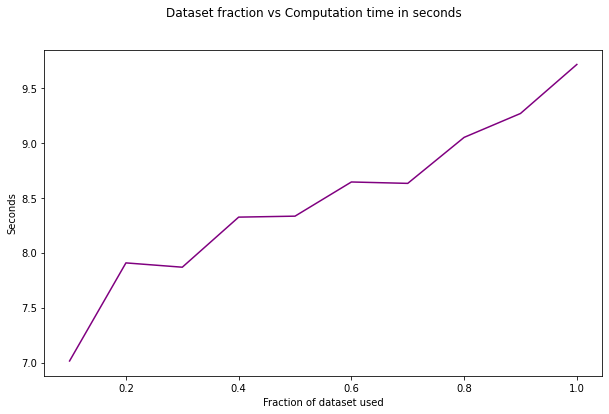

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]

fig = plt.figure()
plt.plot(graph1["Dataset Fraction"],graph1["Computation time"], c='purple')
fig.suptitle('Dataset fraction vs Computation time in seconds')
plt.xlabel('Fraction of dataset used')
plt.ylabel('Seconds')


In [ ]:
ukraine_en.shape[0]

157974

In [ ]:
# predicting time required 
x = np.array(graph1['Dataset Fraction']*ukraine_en.shape[0])
x = x.reshape(-1, 1)
for deg in [1,2,3,4]:
# Fitting Polynomial Regression to the dataset
  poly_reg = PolynomialFeatures(degree=deg)
  X_poly = poly_reg.fit_transform(x)
  pol_reg = LinearRegression()
  pol_reg.fit(X_poly, graph1['Computation time'])
# Predicting with Polymonial Regression
  prediction = pol_reg.predict(poly_reg.fit_transform([[ukraine_en.shape[0]*40]]))
# print(prediction[0])
  time_required = datetime.timedelta(seconds=prediction[0])
  print(str(deg) + str (' degree polynomial: ')+ str(time_required))

1 degree polynomial: 0:01:46.394459
2 degree polynomial: -1 day, 23:52:13.565831
3 degree polynomial: 5 days, 11:23:00.661171
4 degree polynomial: 427 days, 4:39:59.459382


In [ ]:
np.random.seed(1105)
# Try different thresholds for minimum support 
thresholds = [0.005, 0.01, 0.02, 0.04, 0.05, 0.06, 0.08, 0.1]
fpgrowth_comp_time_threshold = {}

for thres in tqdm( thresholds ):
  fpGrowth = FPGrowth(itemsCol="tokenized2", minSupport = thres)

  # compute time difference
  start_time = time.time()
  model = fpGrowth.fit(spark_en)

  fpgrowth_comp_time_threshold[thres] = time.time() - start_time


100%|██████████| 8/8 [02:03<00:00, 15.40s/it]


In [ ]:
fpgrowth_comp_time_threshold

{0.005: 15.125239610671997,
 0.01: 15.563227653503418,
 0.02: 15.706894636154175,
 0.04: 14.946529626846313,
 0.05: 15.09436821937561,
 0.06: 15.33593487739563,
 0.08: 15.575499057769775,
 0.1: 15.751986742019653}

In [ ]:
graph2 = pd.DataFrame.from_dict(fpgrowth_comp_time_threshold, orient='index')
graph2 =graph2.reset_index()
graph2.columns = ['Minimum Support', 'Computation Time']
graph2
graph2["Minimum Support"] = pd.to_numeric(graph2["Minimum Support"])
graph2["Computation Time"] = pd.to_numeric(graph2["Computation Time"])


Text(0, 0.5, 'Seconds')

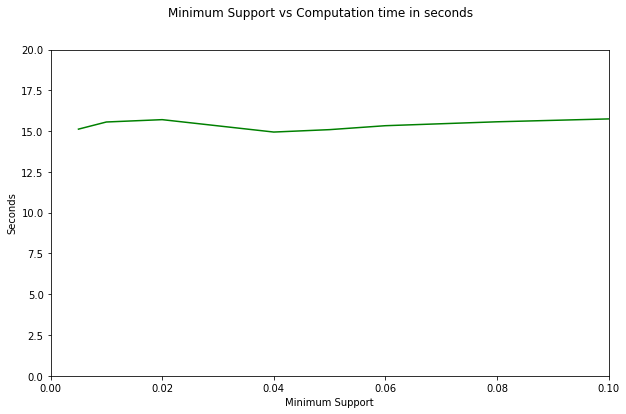

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,6]

fig = plt.figure()
plt.plot(graph2["Minimum Support"],graph2["Computation Time"],c='green')
fig.suptitle('Minimum Support vs Computation time in seconds')
plt.axis([0,0.1, 0, 20])
plt.xlabel('Minimum Support')
plt.ylabel('Seconds')
